$$
\newcommand{\F}{\mathbb{F}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\A}{\mathbf{A}}
\newcommand{\L}{\mathbf{L}}
\newcommand{\X}{\mathbf{X}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\v}{\mathbf{v}}
\newcommand{\a}{\mathbf{a}}
\newcommand{\b}{\mathbf{b}}
\newcommand{\c}{\mathbf{c}}
\newcommand{\w}{\mathbf{w}}
\newcommand{\u}{\mathbf{u}}
\newcommand{\0}{\mathbf{0}}
\newcommand{\1}{\mathbf{1}}
$$

## Dependencies and Config

In [197]:
from typing import *

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchsummary
import torchvision
from torch.utils import data
from torchvision import datasets, transforms
from torchvision.models import vgg19, resnet34

import os
import random
# Display
from IPython.display import Image, display
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
%cd ..
import utils

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
utils.seed_all()

We will be using three sample images from ImageNet dataset.

In [5]:
elephant_path = "../images/animals/elephant.png"
single_cat_path = "../images/animals/cat.jpg"
dog_and_cat_path = "../images/animals/dog_and_cat.jpg"

## Dataset and Dataloader

We create a simple PyTorch `Dataset` that reads and return one single image, this is to illustrate our example easily.

In [6]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, image_path, target=None, transform=None):
        """This Dataset reads 1 image at a time.

        Args:
            image_path (_type_): The path to the image
            target (_type_): The target class of the image
            transform (_type_, optional): The transform to apply to the image
        """
        self.image_path = image_path
        self.target = target
        self.transform = transform

    def __len__(self):
        """This loader only returns 1 image at a time

        Returns:
            The length of the dataset
        """
        return 1

    def __getitem__(self, x):
        # read 1 image only so no need subset idx
        image_path = self.image_path
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.target is None:
            # force assign 0 tensor to be compatible with loader
            self.target = torch.zeros(0)

        if self.transform is not None:
            image = self.transform(image)

        return image, self.target

### Transforms

We use some default transforms of image size 224 with ImageNet mean and standard deviation.

In [7]:
# use the ImageNet transformation
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)

### Create the DataLoaders

We create the three datasets and dataloaders below.

In [8]:
# define a 1 image dataset
elephant_dataset = CustomDataset(image_path=elephant_path, transform=transform)
cat_dataset = CustomDataset(image_path=single_cat_path, transform=transform)
dog_and_cat_dataset = CustomDataset(
    image_path=dog_and_cat_path, transform=transform
)

# define the dataloader to load that single image
elephant_dataloader = torch.utils.data.DataLoader(
    dataset=elephant_dataset, shuffle=False, batch_size=1
)
cat_dataloader = torch.utils.data.DataLoader(
    dataset=cat_dataset, shuffle=False, batch_size=1
)
dog_and_cat_dataloader = torch.utils.data.DataLoader(
    dataset=dog_and_cat_dataset, shuffle=False, batch_size=1
)

### Sanity Check

We get a feel if our dataloader is working by plotting the image in the loader.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


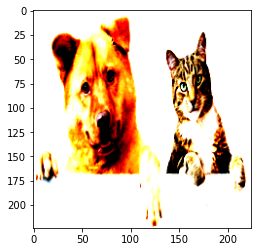

In [9]:
# get some random training images
dataiter = iter(dog_and_cat_dataloader)
images, targets = dataiter.next()

# show images

plt.imshow(np.transpose(torchvision.utils.make_grid(images), (1, 2, 0)))

## Models

### Checking the Layers

We use a library to output the layer information like Keras's `model.summary()`.

We need to identify the last convolutional layer.

In [10]:
def torchsummary_wrapper(
    model, image_size: Tuple[int, int, int]
) -> torchsummary.model_statistics.ModelStatistics:
    """A torch wrapper to print out layers of a Model.

    Args:
        model (CustomNeuralNet): Model.
        image_size (Tuple[int, int, int]): Image size as a tuple of (channels, height, width).

    Returns:
        model_summary (torchsummary.model_statistics.ModelStatistics): Model summary.
    """

    model_summary = torchsummary.summary(model, image_size)
    return model_summary

In [106]:
vgg19_ = vgg19(pretrained=True)
resnet34_ = resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\reighns/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [12]:
vgg19_model_summary = torchsummary_wrapper(vgg19_, image_size = (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

In [109]:
# resnet34_model_summary = torchsummary_wrapper(resnet34_, image_size = (3, 224, 224))

### Define our Target Layers

We define what our target layers would be for the respective models.

In [317]:
# this is the last conv layer layer 35 from Francis's book right after conv2d + relu, but https://github.com/jacobgil/pytorch-grad-cam suggests [-1] where it is max pooled. Can try both.
vgg19_last_conv_layer = vgg19_.features[-2]
print(vgg19_last_conv_layer)


resnet34_last_conv_layer = resnet34_.layer4[-1]
print(resnet34_last_conv_layer)

ReLU(inplace=True)
BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### Store Forward and Backward Hooks

These function help us to get forward activations and backward gradients.

In [111]:
forward_activations = OrderedDict()
backward_gradients = OrderedDict()

def get_forward_hook(name: str) -> Callable:
    """Get the intermediate features of a model. Forward Hook.
    This is using forward hook with reference https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/5
    Args:
        name (str): name of the layer.
    Returns:
        Callable: [description]
    """

    def forward_hook(model, input, output):
        forward_activations[name] = output.detach()

    return forward_hook


def get_backward_hook(name: str) -> Callable:
    """Get the intermediate features of a model. Backward Hook.
    This is using backward hook with reference https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/5
    Args:
        name (str): name of the layer.
    Returns:
        Callable: [description]
    """

    def backward_hook(model, grad_input, grad_output):
        backward_gradients[name] = grad_output[0].detach()

    return backward_hook

## Step by Step Walkthrough

Skip to the next section if you are familiar with the Grad-CAM process.

In [87]:
vgg19_last_conv_layer.register_forward_hook(get_forward_hook("features.35"))
vgg19_last_conv_layer.register_backward_hook(get_backward_hook("features.35")) # register_backward_hook deprecated but for now we use it

In [88]:
# set the evaluation mode
vgg19_.eval()

# get the image from the dataloader
image, _ = next(iter(elephant_dataloader))

# the y_logits before softmax
y_logits = vgg19_(image)

target_category = None

if target_category is None:
    # get the most likely prediction of the model
    target_category = vgg19_(image).argmax(dim=1)
    target_category = target_category.item() # convert to scalar

In [89]:
# get the activations of the last convolutional layer
forward_conv_activations = forward_activations["features.35"]

In [90]:
y_logits[:, target_category].backward()
dyc_dA = backward_gradients["features.35"]

In [91]:
# average pool the gradients across the channels
global_average_pooled_gradients = torch.mean(dyc_dA, dim=[0, 2, 3])

In [92]:
num_feature_maps = 512
weighted_localization_map = torch.clone(forward_conv_activations)

# weight the channels by corresponding gradients
for i in range(num_feature_maps):
    weighted_localization_map[:, i, :, :] *= global_average_pooled_gradients[i]
    
# sum the channels of the activations
weighted_localization_map = torch.sum(weighted_localization_map, dim=1).squeeze()
assert weighted_localization_map.shape == (14, 14)

In [93]:
# relu on top of the heatmap expression (2) in https://arxiv.org/pdf/1610.02391.pdf
relu_weighted_localization_map = torch.nn.ReLU(inplace=False)(weighted_localization_map)

tensor([[0.1695, 0.1367, 0.1292, 0.1435, 0.1037, 0.0376, 0.0048, 0.0520, 0.1114,
         0.1495, 0.1856, 0.1638, 0.0733, 0.2405],
        [0.1262, 0.0933, 0.1134, 0.1632, 0.0805, 0.0000, 0.0000, 0.0254, 0.1456,
         0.2702, 0.2565, 0.1883, 0.0819, 0.1331],
        [0.1508, 0.1267, 0.1541, 0.2010, 0.0570, 0.0000, 0.0000, 0.0973, 0.5866,
         0.8733, 0.8954, 0.7577, 0.2693, 0.2221],
        [0.1884, 0.1376, 0.0959, 0.0888, 0.0000, 0.0000, 0.0715, 0.3818, 0.8004,
         1.0000, 0.9425, 0.7478, 0.2823, 0.1800],
        [0.1931, 0.1158, 0.0351, 0.1330, 0.1786, 0.1146, 0.1243, 0.3891, 0.6943,
         0.7773, 0.6895, 0.5610, 0.2427, 0.1264],
        [0.1552, 0.1056, 0.0473, 0.2595, 0.4205, 0.4517, 0.3047, 0.2987, 0.3538,
         0.3354, 0.3093, 0.3014, 0.2003, 0.1028],
        [0.1290, 0.0747, 0.0794, 0.2144, 0.3984, 0.4928, 0.3979, 0.2380, 0.1140,
         0.0156, 0.0354, 0.1017, 0.0838, 0.0565],
        [0.1351, 0.0931, 0.0892, 0.2174, 0.2635, 0.2547, 0.2120, 0.0853, 0.0532,
  

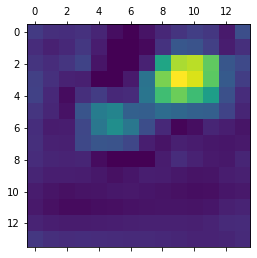

In [96]:
# normalize the heatmap, scale features to between 0 and 1 to plot
heatmap = relu_weighted_localization_map / torch.max(relu_weighted_localization_map)
# draw the heatmap
plt.matshow(heatmap.squeeze())

In [95]:
img = cv2.imread(elephant_path)

heatmap = cv2.resize(heatmap.cpu().detach().numpy(), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

cv2.imwrite('./elephant_gradcam.jpg', superimposed_img)

True

## Function for Grad-CAM Heatmap

In [112]:
def make_gradcam_heatmap(
    target_layer: torch.nn.Module,
    target_layer_name: str,
    model: torch.nn.Module,
    image: torch.Tensor,
    target_category: Optional[int] = None,
):
    """_summary_

    Args:
        target_layer (str): _description_
        model (torch.nn.Module): _description_
        image (torch.Tensor): _description_
        target_category (Optional[int], optional): _description_. Defaults to None.
    """
    target_layer.register_forward_hook(
        get_forward_hook(target_layer_name)
    )
    target_layer.register_backward_hook(
        get_backward_hook(target_layer_name)
    )  # register_backward_hook deprecated but for now we use it

    model.eval()
    # the y_logits before softmax
    y_logits = model(image)

    if target_category is None:
        # get the most likely prediction of the model
        target_category = model(image).argmax(dim=1)
        target_category = target_category.item()  # convert to scalar
        

    # get the activations of the last convolutional layer
    forward_conv_activations = forward_activations[target_layer_name]
    y_logits[:, target_category].backward()
    dyc_dA = backward_gradients[target_layer_name]
    # average pool the gradients across the channels
    global_average_pooled_gradients = torch.mean(dyc_dA, dim=[0, 2, 3])

    num_feature_maps = forward_conv_activations.squeeze().shape[0]

    weighted_localization_map = torch.clone(forward_conv_activations)

    # weight the channels by corresponding gradients
    for i in range(num_feature_maps):
        weighted_localization_map[
            :, i, :, :
        ] *= global_average_pooled_gradients[i]

    # sum the channels of the activations
    weighted_localization_map = torch.sum(
        weighted_localization_map, dim=1
    ).squeeze()
    # relu on top of the heatmap expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    relu_weighted_localization_map = torch.nn.ReLU(inplace=False)(
        weighted_localization_map
    )
    # normalize the heatmap, scale features to between 0 and 1 to plot
    heatmap = relu_weighted_localization_map / torch.max(
        relu_weighted_localization_map
    )

    # draw the heatmap
    plt.matshow(heatmap.squeeze())

    return heatmap


In [303]:
cat_image, _ = next(iter(cat_dataloader))
dog_and_cat_image, _ = next(iter(dog_and_cat_dataloader))
elephant_image, _ = next(iter(elephant_dataloader))

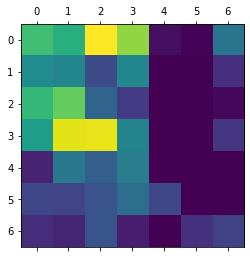

In [304]:
dog_and_cat_heatmap = make_gradcam_heatmap(
    target_layer=vgg19_last_conv_layer,
    target_layer_name = "vgg19.feature.35",
    model=vgg19_,
    image=dog_and_cat_image,
    target_category=None
)

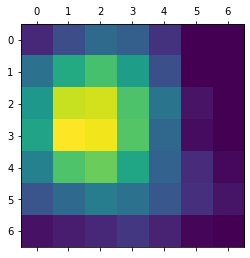

In [305]:
dog_and_cat_heatmap_resnet34 = make_gradcam_heatmap(
    target_layer=resnet34_last_conv_layer,
    target_layer_name = "resnet34.layer4[-1]",
    model=resnet34_,
    image=dog_and_cat_image,
    target_category=None
)

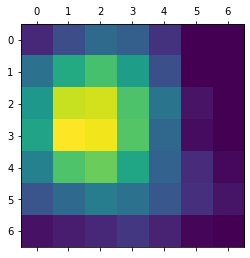

In [306]:
dog_and_cat_heatmap_resnet34_target_dog = make_gradcam_heatmap(
    target_layer=resnet34_last_conv_layer,
    target_layer_name = "resnet34.layer4[-1]",
    model=resnet34_,
    image=dog_and_cat_image,
    target_category=260
)

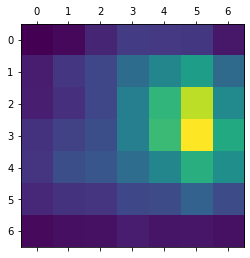

In [307]:
dog_and_cat_heatmap_resnet34_target_cat = make_gradcam_heatmap(
    target_layer=resnet34_last_conv_layer,
    target_layer_name = "resnet34.layer4[-1]",
    model=resnet34_,
    image=dog_and_cat_image,
    target_category=285
)

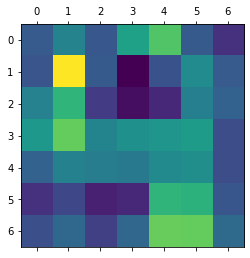

In [308]:
cat_heatmap = make_gradcam_heatmap(
    target_layer=vgg19_last_conv_layer,
    target_layer_name = "vgg19.feature.35",
    model=vgg19_,
    image=cat_image,
    target_category=None
)

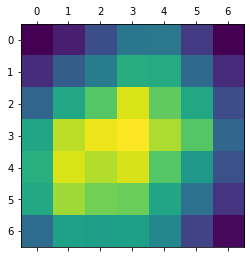

In [309]:
cat_heatmap_resnet34 = make_gradcam_heatmap(
    target_layer=resnet34_last_conv_layer,
    target_layer_name = "resnet34.layer4[-1]",
    model=resnet34_,
    image=cat_image,
    target_category=None
)

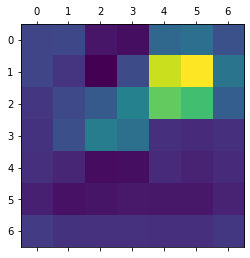

In [310]:
elephant_heatmap = make_gradcam_heatmap(
    target_layer=vgg19_last_conv_layer,
    target_layer_name = "vgg19.features.35",
    model=vgg19_,
    image=elephant_image,
    target_category=None
)

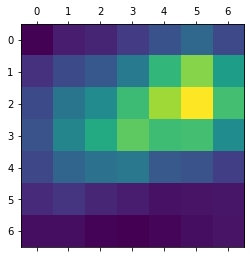

In [311]:
elephant_heatmap_resnet34 = make_gradcam_heatmap(
    target_layer=resnet34_last_conv_layer,
    target_layer_name = "resnet34.layer4[-1]",
    model=resnet34_,
    image=elephant_image,
    target_category=None
)

In [312]:
# def save_and_display_gradcam(
#     image_path, heatmap, image_size=None, cam_path="./cat_gradcam.jpg", alpha=0.4
# ):
#     # cv2 imread auto reads as BGR
#     image = cv2.imread(image_path)
#     if image_size is not None:
#         image = cv2.resize(image, (image_size, image_size))
  

#     if not isinstance(heatmap, np.ndarray):
#         heatmap = heatmap.cpu().detach().numpy()

#     heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
#     heatmap = np.uint8(255 * heatmap)
#     heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
#     superimposed_image = heatmap * alpha + image
    
    
#     cv2.imwrite(cam_path, superimposed_image)

#     return np.uint8(superimposed_image)


In [313]:
def save_and_display_gradcam(
    image_path,
    heatmap,
    image_size=None,
    cam_path="./cat_gradcam.jpg",
    alpha=0.4,
    use_rgb=False,
):
    """_summary_

    Args:
        image_path (_type_): _description_
        heatmap (_type_): _description_
        image_size (_type_, optional): _description_. Defaults to None.
        cam_path (str, optional): _description_. Defaults to "./cat_gradcam.jpg".
        alpha (float, optional): _description_. Defaults to 0.4.

    Returns:
        _type_: _description_
    """
    # Load original image, cv2 imread auto reads as BGR
    image = cv2.imread(image_path)
    if image_size is not None:
        image = cv2.resize(image, (image_size, image_size))

    if isinstance(heatmap, torch.Tensor):
        heatmap = heatmap.cpu().detach().numpy()

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
   
    # Use Jet colormap to colorize heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    if use_rgb:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        
    # resize heatmap to original image size
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    superimposed_image = heatmap * alpha + image
    cv2.imwrite(cam_path, superimposed_image)
 
    # Display Grad CAM
    display(Image(cam_path))

    return np.uint8(superimposed_image)

In [314]:
# def save_and_display_gradcam(
#     image_path, heatmap, cam_path="./cat_gradcam.jpg", alpha=0.4
# ):
#     image = cv2.imread(image_path)

#     heatmap = cv2.resize(
#         heatmap.cpu().detach().numpy(), (image.shape[1], image.shape[0])
#     )
#     heatmap = np.uint8(255 * heatmap)
#     heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
#     superimposed_image = heatmap * alpha + image

#     cv2.imwrite(cam_path, superimposed_image)

#     return superimposed_image

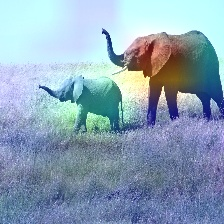

In [315]:
elephant_gradcam_vgg19 = save_and_display_gradcam(image_path = elephant_path, heatmap = elephant_heatmap,  image_size=224, cam_path="./elephant_gradcam.jpg", alpha=0.4,  use_rgb=False)

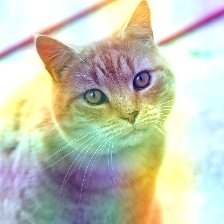

In [316]:
cat_gradcam_vgg19 = save_and_display_gradcam(image_path = single_cat_path, heatmap = cat_heatmap,image_size=224, cam_path="./cat_gradcam.jpg", alpha=0.4,  use_rgb=False)

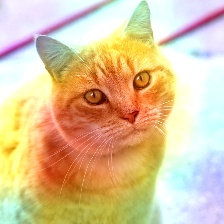

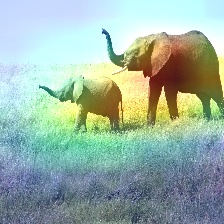

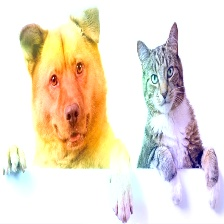

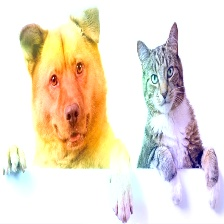

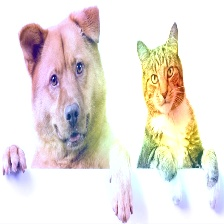

In [299]:
cat_gradcam_resnet34 = save_and_display_gradcam(image_path = single_cat_path, heatmap = cat_heatmap_resnet34,image_size=224, cam_path="./cat_gradcam_resnet34.jpg", alpha=0.4)
elephant_gradcam_resnet34 = save_and_display_gradcam(image_path = elephant_path, heatmap = elephant_heatmap_resnet34, image_size=224, cam_path="./elephant_gradcam_resnet34.jpg", alpha=0.4)
dog_and_cat_gradcam_resnet34 = save_and_display_gradcam(image_path = dog_and_cat_path, heatmap = dog_and_cat_heatmap_resnet34, image_size=224, cam_path="./dog_and_cat_gradcam_resnet34.jpg", alpha=0.4)
dog_and_cat_gradcam_resnet34_target_dog = save_and_display_gradcam(image_path = dog_and_cat_path, heatmap = dog_and_cat_heatmap_resnet34_target_dog, image_size=224, cam_path="./dog_and_cat_gradcam_target_dog_resnet34.jpg", alpha=0.4)
dog_and_cat_gradcam_resnet34_target_dog = save_and_display_gradcam(image_path = dog_and_cat_path, heatmap = dog_and_cat_heatmap_resnet34_target_cat, image_size=224, cam_path="./dog_and_cat_gradcam_target_cat_resnet34.jpg", alpha=0.4)


In [101]:
save_and_display_gradcam(image_path = dog_and_cat_path, heatmap = dog_and_cat_heatmap, cam_path="./dog_and_cat_gradcam.jpg", alpha=0.4)

In [72]:

image = cv2.imread(single_cat_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# needed for gradcam.
original_image = cv2.resize(
    image,
    (224, 224))

In [118]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50, vgg19, resnet34

model = resnet34(pretrained=True)
target_layers = [model.layer4[-1]]
input_tensor = cat_image # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

In [119]:


# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.
target_category = None

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]


In [120]:
cat_image_normalized = original_image / 255.
cat_image_normalized.shape

(224, 224, 3)

In [121]:
visualization = show_cam_on_image(cat_image_normalized, grayscale_cam, use_rgb=True)

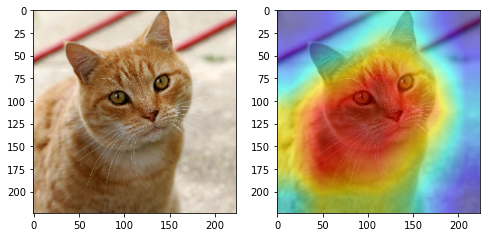

In [122]:

_fig, axes = plt.subplots(figsize=(8, 8), ncols=2)
axes[0].imshow(cat_image_normalized)

axes[1].imshow(visualization)

plt.show()
torch.cuda.empty_cache()